# Supply-Demand Matching: Aligning Resources with Time-Varying Needs

This notebook demonstrates a core challenge in scheduling: **matching supply (resources) with demand that varies over time**.

Understanding supply-demand matching is critical because:
- Demand varies dramatically across time periods (hours, days, weeks)
- Supply is usually relatively fixed or changes slowly
- Mismatches create either waste (overstaffing) or service problems (understaffing)
- The challenge is aligning variable demand with relatively fixed supply


## Key Concepts

**Demand** varies over time:
- Peaks during certain hours, days, or seasons
- Valleys during other periods
- Often unpredictable and variable
- Examples: Customer traffic, call volume, patient arrivals

**Supply** is relatively fixed:
- Limited number of employees, equipment, or facilities
- Can be adjusted but with costs and time delays
- Examples: Staff members, delivery trucks, hospital beds

**The Matching Challenge**:
- Align variable demand with fixed supply
- Understaffing creates service problems (long waits, poor quality)
- Overstaffing creates cost problems (wasted resources)
- The goal is to minimize both problems

**Critical insight**: Perfect alignment is usually impossible. The challenge is finding the right balance between service quality and cost efficiency.


## Scenario: Call Center Staffing

You manage a customer service call center that operates 24 hours a day, 7 days a week. You must schedule agents to handle incoming calls.

**Demand patterns**:
- Weekday business hours (9 AM - 5 PM): High call volume
- Weekday evenings (5 PM - 9 PM): Moderate call volume
- Weekday nights (9 PM - 9 AM): Low call volume
- Weekends: Very low call volume

**Supply constraints**:
- You have 20 agents available
- Each agent can work up to 40 hours per week
- Agents prefer consistent schedules
- Hiring new agents takes time and costs money

**Challenge**: How do you schedule agents to match demand while controlling costs?


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you may need to install packages. This cell can be skipped if running locally and packages are already installed.


In [1]:
# Install required packages if needed (for Google Colab)
# Can be skipped if already installed locally
%pip install matplotlib pandas numpy -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


## Step 3: Define Demand Patterns

Let's create a realistic demand pattern that varies throughout the week:


In [3]:
# Define time periods (24 hours, 7 days = 168 periods)
# For simplicity, we'll use 4-hour blocks: Morning (6-10), Midday (10-14), Afternoon (14-18), Evening (18-22), Night (22-6)

# Create demand pattern (calls per hour, averaged over 4-hour period)
# Higher during business hours, lower at night and weekends
demand_pattern = {
    'Monday': {'Morning': 45, 'Midday': 60, 'Afternoon': 55, 'Evening': 30, 'Night': 10},
    'Tuesday': {'Morning': 50, 'Midday': 65, 'Afternoon': 60, 'Evening': 35, 'Night': 12},
    'Wednesday': {'Morning': 48, 'Midday': 62, 'Afternoon': 58, 'Evening': 32, 'Night': 11},
    'Thursday': {'Morning': 52, 'Midday': 68, 'Afternoon': 62, 'Evening': 38, 'Night': 13},
    'Friday': {'Morning': 55, 'Midday': 70, 'Afternoon': 65, 'Evening': 40, 'Night': 15},
    'Saturday': {'Morning': 20, 'Midday': 25, 'Afternoon': 22, 'Evening': 18, 'Night': 8},
    'Sunday': {'Morning': 15, 'Midday': 18, 'Afternoon': 16, 'Evening': 12, 'Night': 6}
}

# Convert to flat list for easier plotting
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
periods = ['Morning', 'Midday', 'Afternoon', 'Evening', 'Night']

demand_data = []
for day in days:
    for period in periods:
        demand_data.append({
            'Day': day,
            'Period': period,
            'Demand': demand_pattern[day][period]
        })

demand_df = pd.DataFrame(demand_data)

# Create time index for plotting
demand_df['TimeIndex'] = range(len(demand_df))

print("DEMAND PATTERN (Calls per Hour):")
print("=" * 70)
display(demand_df.head(10))
print(f"\n... (showing first 10 of {len(demand_df)} periods) ...")

print(f"\nPeak demand: {demand_df['Demand'].max()} calls/hour")
print(f"Lowest demand: {demand_df['Demand'].min()} calls/hour")
print(f"Average demand: {demand_df['Demand'].mean():.1f} calls/hour")


DEMAND PATTERN (Calls per Hour):


,Day,Period,Demand,TimeIndex
0,Monday,Morning,45,0
1,Monday,Midday,60,1
2,Monday,Afternoon,55,2
3,Monday,Evening,30,3
4,Monday,Night,10,4
5,Tuesday,Morning,50,5
6,Tuesday,Midday,65,6
7,Tuesday,Afternoon,60,7
8,Tuesday,Evening,35,8
9,Tuesday,Night,12,9



... (showing first 10 of 35 periods) ...

Peak demand: 70 calls/hour
Lowest demand: 6 calls/hour
Average demand: 36.3 calls/hour


## Step 4: Visualize Demand Pattern

Let's see how demand varies throughout the week:


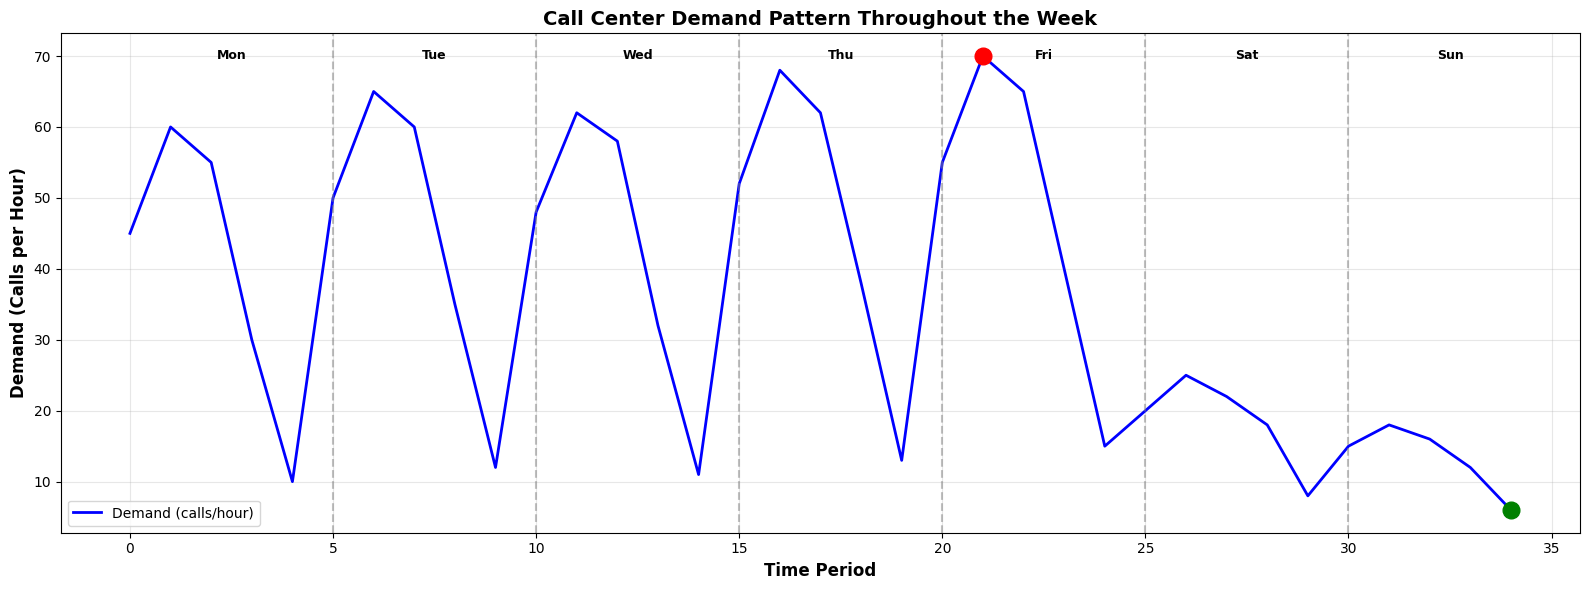


Key Observations:
  - Peak demand: 70 calls/hour (Friday Midday)
  - Lowest demand: 6 calls/hour (Sunday Night)
  - Demand varies by factor of 11.7x
  - Weekday business hours have highest demand
  - Nights and weekends have lowest demand


In [4]:
fig, ax = plt.subplots(figsize=(16, 6))

# Plot demand over time
ax.plot(demand_df['TimeIndex'], demand_df['Demand'], 'b-', linewidth=2, label='Demand (calls/hour)')

# Add day separators
day_starts = [i * 5 for i in range(7)]  # 5 periods per day
for day_start in day_starts[1:]:
    ax.axvline(x=day_start, color='gray', linestyle='--', alpha=0.5)

# Add day labels
day_labels = []
for i, day in enumerate(days):
    day_labels.append(f"{day[:3]}")
    ax.text(i * 5 + 2.5, ax.get_ylim()[1] * 0.95, day_labels[i], 
            ha='center', fontsize=9, fontweight='bold')

# Formatting
ax.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Demand (Calls per Hour)', fontsize=12, fontweight='bold')
ax.set_title('Call Center Demand Pattern Throughout the Week', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Highlight peak and valley
peak_idx = demand_df['Demand'].idxmax()
valley_idx = demand_df['Demand'].idxmin()
ax.plot(peak_idx, demand_df.loc[peak_idx, 'Demand'], 'ro', markersize=12, label='Peak Demand')
ax.plot(valley_idx, demand_df.loc[valley_idx, 'Demand'], 'go', markersize=12, label='Lowest Demand')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"  - Peak demand: {demand_df.loc[peak_idx, 'Demand']} calls/hour ({demand_df.loc[peak_idx, 'Day']} {demand_df.loc[peak_idx, 'Period']})")
print(f"  - Lowest demand: {demand_df.loc[valley_idx, 'Demand']} calls/hour ({demand_df.loc[valley_idx, 'Day']} {demand_df.loc[valley_idx, 'Period']})")
print(f"  - Demand varies by factor of {demand_df.loc[peak_idx, 'Demand'] / demand_df.loc[valley_idx, 'Demand']:.1f}x")
print(f"  - Weekday business hours have highest demand")
print(f"  - Nights and weekends have lowest demand")


In [5]:
# Assume each agent can handle 3 calls per hour on average
calls_per_agent_per_hour = 3

# Calculate required staffing for each period
demand_df['Required_Staff'] = np.ceil(demand_df['Demand'] / calls_per_agent_per_hour).astype(int)

# Scenario 1: Constant staffing (same number of agents all the time)
# Use enough to handle average demand
constant_staff = int(np.ceil(demand_df['Demand'].mean() / calls_per_agent_per_hour))
demand_df['Constant_Staff'] = constant_staff

# Scenario 2: Match demand exactly (ideal but may not be practical)
demand_df['Match_Demand_Staff'] = demand_df['Required_Staff']

# Scenario 3: Minimum staffing (just enough for peak, accept service degradation during peaks)
min_staff = demand_df['Required_Staff'].min()
demand_df['Min_Staff'] = min_staff

# Scenario 4: Peak staffing (enough for peak, overstaffed during valleys)
peak_staff = demand_df['Required_Staff'].max()
demand_df['Peak_Staff'] = peak_staff

print("STAFFING SCENARIOS:")
print("=" * 70)
print(f"\nScenario 1 - Constant Staffing: {constant_staff} agents (handles average demand)")
print(f"Scenario 2 - Match Demand: Varies from {demand_df['Required_Staff'].min()} to {demand_df['Required_Staff'].max()} agents")
print(f"Scenario 3 - Minimum Staffing: {min_staff} agents (handles lowest demand)")
print(f"Scenario 4 - Peak Staffing: {peak_staff} agents (handles peak demand)")

print("\n" + "=" * 70)
print("STAFFING COMPARISON (First 10 periods):")
print("=" * 70)
display(demand_df[['Day', 'Period', 'Demand', 'Required_Staff', 'Constant_Staff', 'Match_Demand_Staff']].head(10))


STAFFING SCENARIOS:

Scenario 1 - Constant Staffing: 13 agents (handles average demand)
Scenario 2 - Match Demand: Varies from 2 to 24 agents
Scenario 3 - Minimum Staffing: 2 agents (handles lowest demand)
Scenario 4 - Peak Staffing: 24 agents (handles peak demand)

STAFFING COMPARISON (First 10 periods):


,Day,Period,Demand,Required_Staff,Constant_Staff,Match_Demand_Staff
0,Monday,Morning,45,15,13,15
1,Monday,Midday,60,20,13,20
2,Monday,Afternoon,55,19,13,19
3,Monday,Evening,30,10,13,10
4,Monday,Night,10,4,13,4
5,Tuesday,Morning,50,17,13,17
6,Tuesday,Midday,65,22,13,22
7,Tuesday,Afternoon,60,20,13,20
8,Tuesday,Evening,35,12,13,12
9,Tuesday,Night,12,4,13,4


## Step 6: Visualize Supply-Demand Matching

Let's see how different staffing scenarios align with demand:


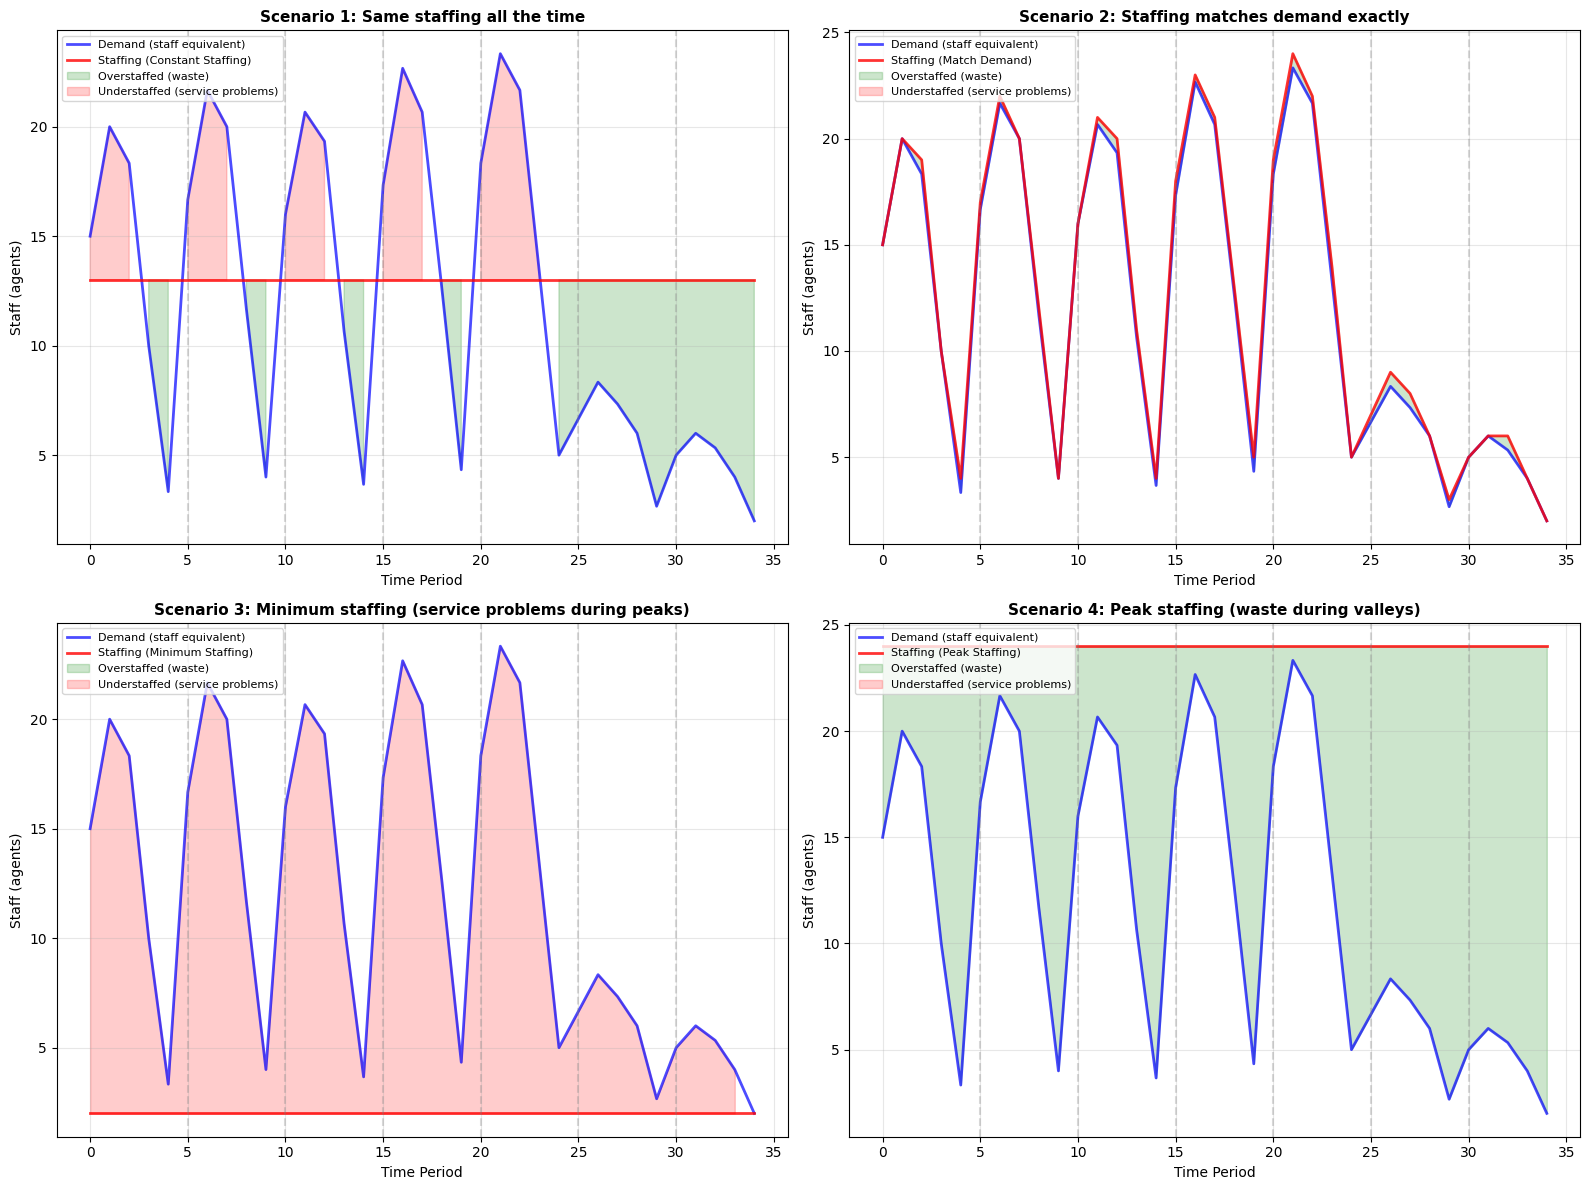


Key Observations:
  - Constant staffing: Overstaffed during valleys, understaffed during peaks
  - Match demand: Perfect alignment but requires flexible scheduling
  - Minimum staffing: Always understaffed except during lowest demand
  - Peak staffing: Always adequate but wasteful during low demand


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Convert demand to staff equivalent for comparison
demand_staff_equivalent = demand_df['Demand'] / calls_per_agent_per_hour

scenarios = [
    ('Constant Staffing', 'Constant_Staff', 'Scenario 1: Same staffing all the time'),
    ('Match Demand', 'Match_Demand_Staff', 'Scenario 2: Staffing matches demand exactly'),
    ('Minimum Staffing', 'Min_Staff', 'Scenario 3: Minimum staffing (service problems during peaks)'),
    ('Peak Staffing', 'Peak_Staff', 'Scenario 4: Peak staffing (waste during valleys)')
]

for idx, (title, col, desc) in enumerate(scenarios):
    ax = axes[idx // 2, idx % 2]
    
    # Plot demand (as staff equivalent)
    ax.plot(demand_df['TimeIndex'], demand_staff_equivalent, 'b-', linewidth=2, 
            label='Demand (staff equivalent)', alpha=0.7)
    
    # Plot staffing
    ax.plot(demand_df['TimeIndex'], demand_df[col], 'r-', linewidth=2, 
            label=f'Staffing ({title})', alpha=0.8)
    
    # Fill areas showing mismatch
    ax.fill_between(demand_df['TimeIndex'], demand_staff_equivalent, demand_df[col], 
                    where=(demand_df[col] >= demand_staff_equivalent),
                    alpha=0.2, color='green', label='Overstaffed (waste)')
    ax.fill_between(demand_df['TimeIndex'], demand_staff_equivalent, demand_df[col], 
                    where=(demand_df[col] < demand_staff_equivalent),
                    alpha=0.2, color='red', label='Understaffed (service problems)')
    
    # Day separators
    for day_start in day_starts[1:]:
        ax.axvline(x=day_start, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Time Period', fontsize=10)
    ax.set_ylabel('Staff (agents)', fontsize=10)
    ax.set_title(desc, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper left')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Constant staffing: Overstaffed during valleys, understaffed during peaks")
print("  - Match demand: Perfect alignment but requires flexible scheduling")
print("  - Minimum staffing: Always understaffed except during lowest demand")
print("  - Peak staffing: Always adequate but wasteful during low demand")


## Step 7: Analyze Service Quality and Cost Tradeoffs

Let's quantify the impact of different staffing scenarios:


In [7]:
# Calculate metrics for each scenario
hourly_wage = 25  # $ per hour per agent
periods_per_week = len(demand_df)

scenario_analysis = []

for title, col in [('Constant', 'Constant_Staff'), ('Match Demand', 'Match_Demand_Staff'), 
                    ('Minimum', 'Min_Staff'), ('Peak', 'Peak_Staff')]:
    
    # Calculate capacity (calls that can be handled)
    capacity = demand_df[col] * calls_per_agent_per_hour
    
    # Calculate service metrics
    understaffed_periods = (demand_df['Demand'] > capacity).sum()
    overstaffed_periods = (demand_df['Demand'] < capacity * 0.8).sum()  # More than 20% excess
    
    # Calculate unmet demand (service problems)
    unmet_demand = np.maximum(0, demand_df['Demand'] - capacity).sum()
    service_deficit_pct = (unmet_demand / demand_df['Demand'].sum()) * 100
    
    # Calculate waste (excess capacity)
    excess_capacity = np.maximum(0, capacity - demand_df['Demand']).sum()
    waste_pct = (excess_capacity / capacity.sum()) * 100
    
    # Calculate cost (assume 4-hour periods, so multiply by 4 for hours)
    total_hours = demand_df[col].sum() * 4
    total_cost = total_hours * hourly_wage
    
    scenario_analysis.append({
        'Scenario': title,
        'Avg Staff': demand_df[col].mean(),
        'Total Cost ($)': total_cost,
        'Understaffed Periods': understaffed_periods,
        'Overstaffed Periods': overstaffed_periods,
        'Service Deficit (%)': service_deficit_pct,
        'Waste (%)': waste_pct
    })

analysis_df = pd.DataFrame(scenario_analysis)

print("SCENARIO COMPARISON:")
print("=" * 90)
display(analysis_df.round(2))

print("\nKey Insights:")
print("  - Constant staffing: Moderate cost, but service problems during peaks")
print("  - Match demand: Best service, but requires flexible scheduling (may have higher costs)")
print("  - Minimum staffing: Lowest cost, but significant service problems")
print("  - Peak staffing: Best service, but highest cost and waste")
print("\n  → The challenge is finding the right balance between cost and service quality")


SCENARIO COMPARISON:


,Scenario,Avg Staff,Total Cost ($),Understaffed Periods,Overstaffed Periods,Service Deficit (%),Waste (%)
0,Constant,13.00,45500,16,16,22.90,28.21
1,Match Demand,12.43,43500,0,0,0.00,2.61
2,Minimum,2.00,7000,34,0,83.48,0.00
3,Peak,24.00,84000,0,26,0.00,49.56



Key Insights:
  - Constant staffing: Moderate cost, but service problems during peaks
  - Match demand: Best service, but requires flexible scheduling (may have higher costs)
  - Minimum staffing: Lowest cost, but significant service problems
  - Peak staffing: Best service, but highest cost and waste

  → The challenge is finding the right balance between cost and service quality


## Step 8: Demonstrate Impact of Demand Variability

What happens when actual demand differs from expected demand?


In [8]:
# Simulate demand variability (actual demand differs from expected)
np.random.seed(42)
variability_factor = 0.2  # 20% variability

# Create actual demand with random variation
demand_df['Actual_Demand'] = demand_df['Demand'] * (1 + np.random.normal(0, variability_factor, len(demand_df)))
demand_df['Actual_Demand'] = np.maximum(5, demand_df['Actual_Demand'])  # Ensure non-negative

# Recalculate with actual demand
demand_df['Actual_Required_Staff'] = np.ceil(demand_df['Actual_Demand'] / calls_per_agent_per_hour).astype(int)

# Compare expected vs actual for constant staffing scenario
expected_capacity = demand_df['Constant_Staff'] * calls_per_agent_per_hour
actual_capacity = demand_df['Constant_Staff'] * calls_per_agent_per_hour

expected_unmet = np.maximum(0, demand_df['Demand'] - expected_capacity).sum()
actual_unmet = np.maximum(0, demand_df['Actual_Demand'] - actual_capacity).sum()

print("IMPACT OF DEMAND VARIABILITY:")
print("=" * 70)
print(f"\nScenario: Constant staffing with {constant_staff} agents")
print(f"Expected demand variability: ±{variability_factor*100:.0f}%")

print(f"\nExpected unmet demand: {expected_unmet:.1f} calls")
print(f"Actual unmet demand: {actual_unmet:.1f} calls")
print(f"Difference: {actual_unmet - expected_unmet:.1f} calls ({((actual_unmet - expected_unmet) / expected_unmet * 100) if expected_unmet > 0 else 0:.1f}% increase)")

print("\nKey Insight:")
print("  - Demand variability makes matching even more challenging")
print("  - Schedules based on expected demand may fail when actual demand differs")
print("  - Buffer capacity may be needed to handle variability")
print("  - This is why robustness matters in scheduling")


IMPACT OF DEMAND VARIABILITY:

Scenario: Constant staffing with 13 agents
Expected demand variability: ±20%

Expected unmet demand: 291.0 calls
Actual unmet demand: 318.2 calls
Difference: 27.2 calls (9.3% increase)

Key Insight:
  - Demand variability makes matching even more challenging
  - Schedules based on expected demand may fail when actual demand differs
  - Buffer capacity may be needed to handle variability
  - This is why robustness matters in scheduling


## Summary: Understanding Supply-Demand Matching

**Demand varies over time**:
- Peaks and valleys create alignment challenges
- Variability makes forecasting difficult
- Perfect prediction is impossible

**Supply is relatively fixed**:
- Limited resources (people, equipment, facilities)
- Adjustments take time and cost money
- Cannot instantly match demand changes

**The Matching Challenge**:
- Understaffing creates service problems (long waits, poor quality)
- Overstaffing creates cost problems (wasted resources)
- Perfect alignment is usually impossible or impractical

**Practical Implications**:
- Understand your demand patterns (when are peaks and valleys?)
- Recognize that some mismatch is inevitable
- Balance cost and service quality based on priorities
- Plan for variability (actual demand will differ from expected)
- Consider buffer capacity for uncertainty
